# Find v sin(i) with Python and MOOG synth

This notebook is used to estimate the projected rotation of solar twin stars using Python, MOOG synth, in addition to RogueAstro's pwoogs and astroChasqui's q2 codes.

Required files:
* s_twins.csv: contains the information of the stars
* filenames.lis: contains the list of names of the spectrum .fits files
* lines.dat: contains information about the lines to be analyzed
* continuum.dat: contains the wavelengths to be used to calibrate the continuum

In [53]:
import numpy as np
from pwoogs import moog,estimate,utils
import matplotlib.pyplot as plt
import q2
import shutil as sh
%matplotlib inline

In [54]:
# Getting star names
star_names = np.loadtxt('s_twins.csv',
                        skiprows=1,
                        usecols=(0,),
                        dtype=str,
                        delimiter=',')

# This is used to manage data arrays
u = utils.arr_manage()

The following function is used to set the input files to be used by MOOG for a specific star from the list star_names.

In [55]:
def set_star(choice, **kwargs):

    if ('inverted_filelist' in kwargs):
        invert = kwargs['inverted_filelist']
    else:
        invert = False
            
    choice = int(choice)
    
    print 'Creating the stellar atmosphere file.'
    
    data = np.loadtxt('s_twins.csv',
                      usecols=(1,2,3,4),
                      skiprows=1,
                      delimiter=',')
    model = q2.modatm.interpolate(data[choice,0],
                                  data[choice,1],
                                  data[choice,2],
                                  grid='odfnew')
    N = len(model['RHOX'])

    with open('star.mod','w') as f:
        f.truncate()
        f.write(
            """KURTYPE
    %.1f/  %.2f/  %.2f      mic =  %.2f                                         
                %i
    5000.0\n""" % (data[choice,0],
                   data[choice,1],
                   data[choice,2],
                   data[choice,3],
                   N)
            )
        for i in range(N):
            f.write(" %.8E   %.1f %.3E %.3E\n" % (
                model['RHOX'][i],
                model['T'][i],
                model['P'][i],
                model['XNE'][i])
            )

        f.write('         %.2f\n' % data[choice,3])
        f.write(
                """NATOMS        0          %.2f
    NMOL         28
    101.0   106.0   107.0   108.0   112.0   126.0
    606.0   607.0   608.0
    707.0   708.0
    808.0   812.0   822.0   823.0   840.0
    10108.0 10820.0 60808.0
    6.1     7.1     8.1   12.1  20.1  22.1  23.1  26.1  40.1
    """ % data[choice,2]
                )
    
    # filenames.lis contains the names of all the fits files of the spectra
    # In my case, the list is in an opposite order as the list of star names,
    # so that's choice is re-set if invert == True
    filename = np.loadtxt('filenames.lis',str)
    if invert == True:
        choice = len(star_names)-1-choice
    print "Creating the spectrum_full.dat file for %s" % filename[choice]
    sh.copyfile(filename[choice],'spectrum_full.dat')

v_m returns the macroturbulent velocity for a solar twin with a temperature T.

In [56]:
def v_m(T):
    return 3.6+(T-5777.)/486

Managing data file because it is possibly huge

In [57]:
def manage(choice, interval, lines, chunk):

    print 'Managing the data file.'
    spec_window = np.array([lines[choice,0]-interval/2,lines[choice,0]+interval/2])
    u.cut(spec_window[0]-chunk,spec_window[1]+chunk,'spectrum_full.dat','spectrum.dat')
    print 'Done.\n'
    
    return spec_window

Function that returns the corrections factors for line center and continuum

In [87]:
def correct(choice, data, lines, cont_type, r_1, r_2, r_3):

    # The following lines are used to find calibration corrections for the spectral line
    print 'Finding the shift on the wavelength.'
    wl_shift = 10.
    ind = u.find_index(lines[choice,0],data[:,0])
    while abs(wl_shift) > 2.0:
        center = u.find_center(data[ind-r_1+1:ind+r_1+2])
        wl_shift = lines[choice,0]-center
    print 'Wavelength shift = %.4f\n' % wl_shift

    print "Finding the correction factor for the continuum."
    ind_min = u.find_index(lines[choice,0]-r_2,data[:,0])
    ind_max = u.find_index(lines[choice,0]+r_2,data[:,0])
    if cont_type == 'single':    
        corr = 1.0/np.mean(u.find_corr(
            data[ind_min:ind_max,:],
            r_3
            ))
    elif cont_type == 'multi':
        target_wls = np.loadtxt('continuum.dat')
        corr = 1.0/np.mean(u.find_corr_from_ensemble(
        data[ind_min:ind_max,:],
        target_wls[choice,:],
        r_3
        ))
    print "Correction factor = %.4f" % corr

    return wl_shift, corr

Next, there is the code that finds the v sin(i) in fully automatic mode, for a specific star.

In [59]:
def full_auto(choice, interval, res_power, SN, **kwargs):
    
    # Spectrum chunk size. Default = 10. angstroms
    if ('chunk' in kwargs):
        chunk = kwargs['chunk']
        assert chunk > interval, 'Invalid chunk size'
    else:
        chunk = 10.0

    # Continuum correction: choose between 'single' or 'multi' wavelengths
    if ('continuum_correction' in kwargs):
        cont_type = kwargs['continuum_correction']
        assert cont_type == 'multi', 'Continuum correction type invalid'
    else:
        cont_type = 'single'
        
    # Radius of points to be used in finding the correction for the line center
    # Default = 3
    if ('r_1' in kwargs):
        radius_1 = kwargs['r_1']
        assert radius_1 > 0, 'Invalid radius for line center correction'
    else:
        radius_1 = 3
        
    # Radius in angstroms for the region around the target wavelength to be
    # analyzed for the continuum . Default = 3.0
    if ('r_2' in kwargs):
        radius_2 = kwargs['r_2']
        assert radius_2 > 0, 'Invalid radius of wavelength region'
    else:
        radius_2 = 3.0
        
    # Radius in points to be used in finding the correction for the continuum.
    # Default = 2
    if ('r_3' in kwargs):
        radius_3 = kwargs['r_3']
        assert radius_3 > 0, 'Invalid radius for continuum correction'
    else:
        radius_3 = 2    
    
    # Radius in points to be used in evaluating the performance function
    # Default = 7
    if ('r_4' in kwargs):
        radius_4 = kwargs['r_4']
        assert radius_4 > 0, 'Invalid radius for performance evaluation'
    else:
        radius_4 = 7
        
    # Blue wing weight to be used on estimation. Default = 10.0
    if ('bw' in kwargs):
        bw = kwargs['bw']
        assert bw >= 0.0, 'Invalid weight for blue wing'
    else:
        bw = 10.0
        
    # Red wing weight to be used on estimation. Default = 5.0
    if ('rw' in kwargs):
        rw = kwargs['rw']
        assert rw >= 0.0, 'Invalid weight for red wing'
    else:
        rw = 5.0

    # Line center weight to be used on estimation. Default = 25.0
    if ('cw' in kwargs):
        cw = kwargs['cw']
        assert cw >= 0.0, 'Invalid weight for line center'
    else:
        cw = 25.0
        
    # Bad fit tolerance in number of points above the S/N ratio. Default = 2
    if ('tol' in kwargs):
        tol = kwargs['tol']
        assert tol >= 0, 'Invalid tolerance'
    else:
        tol = 2
                    
    # 'plot' on window or 'save' as png? Default = plot on window
    if ('output' in kwargs):
        output = kwargs['output']
        assert output == 'save', 'Invalid radius for continuum correction'
    else:
        output = 'plot'
    
    choice = int(choice)

    # Synthesis parameters
    line_file = 'lines.dat'
    lines = np.loadtxt(line_file,skiprows=1,usecols=(0,1))

    # Star parameters
    star_info = np.genfromtxt('star.mod',skip_header=1,skip_footer=83,
                              usecols=(0,1),delimiter='/  ')
    T_star = star_info[0]
    v_macro = v_m(T_star)

    data = np.loadtxt('spectrum.dat')
    
    # Managing the data file
    spec_window = manage(choice, interval, lines, chunk)

    # The instrumental broadening
    gauss = np.mean(spec_window)/res_power

    # Finding the correction factors
    wl_shift, corr = correct(choice, data, lines, cont_type, radius_1, radius_2, 
                             radius_3)
    
    print "Now starting estimation of vsini..."

    # Instatiating the function to write parameters for MOOG
    r = estimate.vsini(
                spec_window,
                gauss,
                v_macro,
                line_file,
                choice,
                x_wl=wl_shift,
                y_mult=corr,
                bwing_w = bw,
                rwing_w = rw,
                center_w = cw,
                perf_radius=radius_4,
                SN=SN,
                badfit_tol = tol,
                star_name=star_names[m]
                )

    if output == 'plot':
        save = 'window'
    else:
        save = '%s_line%i.png'%(star_names[m],choice)
    
    # Finding vsini and abundance
    vsini,abund,bfs = r.find(N=15,
                             max_i=20,
                             min_i=10,
                             limits=[0.05,0.001],
                             save=save)
    return vsini,abund,bfs

Creating the stellar atmosphere file.
Creating the spectrum_full.dat file for iris_ut110104_noheader.dat
Managing the data file.
Done.

Finding the shift on the wavelength.
Wavelength shift = -0.0168

Finding the correction factor for the continuum.
Standard deviation of the spectrum on the selected data points = 0.0015
Correction factor = 0.9997
Now starting estimation of vsini...

Starting estimation of vsini and abundance...

iteration = 1
best vsini = 0.50 (changed 4.750)
best abund = 0.100 (changed 0.1000)

iteration = 2
best vsini = 1.18 (changed 4.071)
best abund = 0.114 (changed 0.0143)

iteration = 3
best vsini = 1.18 (changed 1.696)
best abund = 0.111 (changed 0.0036)

iteration = 4
best vsini = 1.18 (changed 0.509)
best abund = 0.112 (changed 0.0018)

iteration = 5
best vsini = 1.26 (changed 0.085)
best abund = 0.112 (changed 0.0000)

iteration = 6
best vsini = 1.31 (changed 0.042)
best abund = 0.112 (changed 0.0000)

iteration = 7
best vsini = 1.33 (changed 0.021)
best abun

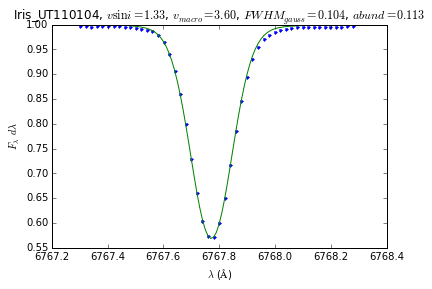

In [90]:
m = 88
set_star(m, inverted_filelist=True)
v, a, b = full_auto(choice=5, interval=1.0, r_1=3, r_2=3.0, r_4=7, res_power=65000., SN=400)